# Continuous grid-world

Here we perform UQ for GFlowNets trained on a continuous grid-world, using PCE.

Import neccessary libraries.

In [17]:
from matplotlib import pyplot as plt
from torch.distributions import Normal, Categorical, MultivariateNormal
import math
import numpy as np
from scipy.stats import norm
import torch
import random
from torch.distributions.categorical import Categorical
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
import tqdm
import torch.optim as optim
from collections import Counter
import networkx as nx
from collections import deque
from tqdm import tqdm
import pandas as pd
import random
from matplotlib.colors import LogNorm
if not hasattr(np, 'bool'):
    np.bool = bool
import chaospy as chaos
from matplotlib.collections import LineCollection
from sklearn.linear_model import LassoCV, RidgeCV
import continuous_grid_helper as h
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
sns.set(font='Times New Roman', style = 'white')

We import a training ensemble of GFN models that have been trained on randomly shifted continuous reward functions.

In [3]:
forward_model_ensemble = []
backward_model_ensemble = []
mus = []
N = 150

for n in range(N):

    forward_model, backward_model, _, _ = h.setup_experiment()

    state_dict_for = torch.load('training_ensemble/cont_for_gfn' + str(n) + '.pth')
    forward_model.load_state_dict(state_dict_for)
    forward_model.eval()
    forward_model_ensemble.append(forward_model)

    state_dict_back = torch.load('training_ensemble/cont_back_gfn' + str(n) + '.pth')
    backward_model.load_state_dict(state_dict_back)
    backward_model.eval()
    backward_model_ensemble.append(backward_model)

    mu = np.array(pd.read_csv('training_ensemble/mus' + str(n) + '.txt',header=None,dtype=float,sep=' '))
    mus.append(mu)

We can sample of import a trajectory on which to extract the policy

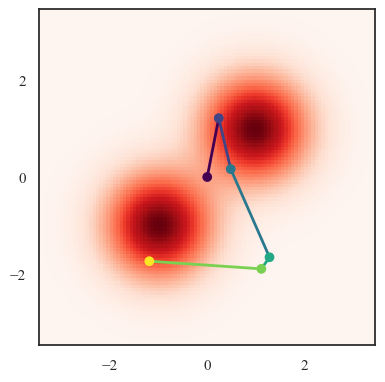

In [5]:
env = h.PlaneEnvironment(mus=[(-1,-1), (1,1)], variances=[0.3, 0.3], n_sd=4.5, init_value=torch.tensor([0,0]))

trajectory = np.loadtxt('sampled_path_cont.csv',dtype=np.float32).reshape(1,6,3)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)

h.render(env,ax)
h.plot_traj(trajectory,ax,h.trajectory_length)

plt.tight_layout()
plt.show()

We can visualise the Gaussian $(x,y)$-policy along this trajectory.

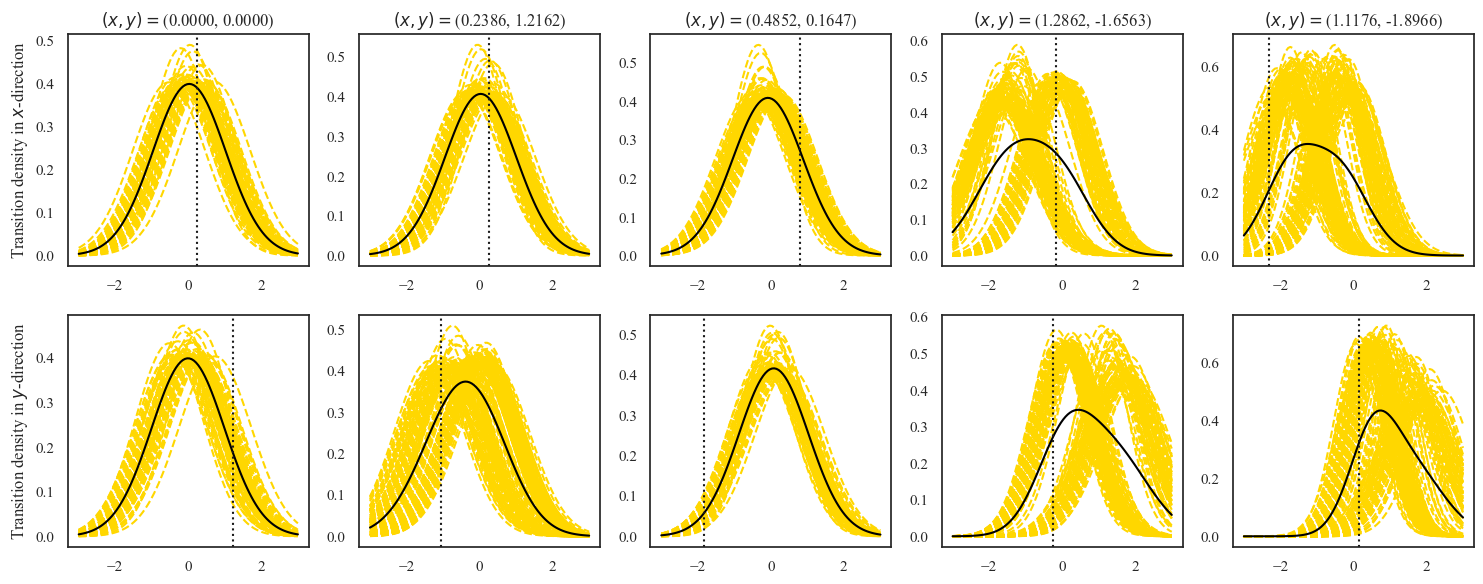

In [6]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(15,6)

for i in range(0,5):
    
    x_dist_mean = np.zeros(100)
    y_dist_mean = np.zeros(100)
    
    for j, forward_model in enumerate(forward_model_ensemble):
        x_dist, y_dist = h.extract_flow_at_point(forward_model,trajectory[:,i,:])
        x_sup = np.linspace(-3, 3, 100)
        y_sup = np.linspace(-3, 3, 100)

        ax[0,i].plot(x_sup,x_dist.pdf(x_sup),color = 'gold',linestyle = 'dashed',label=r'$\mu = $' + f"{x_dist.mean():.2f}, " + r'$\sigma = $' + f"{x_dist.std():.2f}")
        x_dist_mean += x_dist.pdf(x_sup)/len(forward_model_ensemble)
        point = trajectory[0, i, :]
        x, y, _ = point
        ax[0,i].set_title(r'$(x,y) = $' + f"({x:.4f}, {y:.4f})")
        next_point = trajectory[0, i+1, :]
        

        ax[1,i].plot(y_sup,y_dist.pdf(y_sup),color = 'gold',linestyle = 'dashed',label=r'$\mu = $' + f"{y_dist.mean():.2f}, " + r'$\sigma = $' + f"{y_dist.std():.2f}")
        y_dist_mean += y_dist.pdf(y_sup)/len(forward_model_ensemble)
        point = trajectory[0, i, :]
        x, y, _ = point
        next_point = trajectory[0, i+1, :]
    
    ax[0,i].plot(x_sup,x_dist_mean,color = 'black')
    ax[1,i].plot(y_sup,y_dist_mean,color = 'black')
    
    ax[0,i].axvline(next_point[0]-x,linestyle = 'dotted',color = 'k')
    ax[1,i].axvline(next_point[1]-y,linestyle = 'dotted',color = 'k')


ax[0,0].set_ylabel(r'Transition density in $x$-direction')
ax[1,0].set_ylabel(r'Transition density in $y$-direction')
plt.tight_layout()
plt.show()

We turn this into training data for a PCE model.

In [7]:
policy_output = np.zeros((N,20))

for i in range(0,5):
    for j, forward_model in enumerate(forward_model_ensemble):
        x_mean, x_var, y_mean, y_var = h.extract_dist_at_point(forward_model,trajectory[:,i,:])
        policy_output[j,(i*4):((i*4)+4)] = np.array([x_mean, np.log(x_var), y_mean, np.log(y_var)])

reward_input = np.zeros((N,4))

for i, mu in enumerate(mus):
    reward_input[i,:] = mu.reshape(4)

We define our orthonormal polynomial basis and fit the coefficients with Ridge regression

In [8]:
dist_list = [chaos.Normal(-1,np.sqrt(0.1)), chaos.Normal(-1,np.sqrt(0.1)),chaos.Normal(1,np.sqrt(0.1)), chaos.Normal(1,np.sqrt(0.1))]
joint_dist = chaos.J(*dist_list)

degree = 5

orthogonal_expansion = chaos.generate_expansion(
        order=degree,
        dist=joint_dist
    )

coefficients = []

for i in range(policy_output.shape[1]):

    A = orthogonal_expansion(*(reward_input.T))
    A = A.T
    model = RidgeCV(cv=5, fit_intercept=False).fit(A, policy_output[:,i])
    coeffs = model.coef_

    coefficients.append(coeffs)

We then sample new inputs from the distribution and predict outputs at this point with the fitted PCE model.

In [9]:
def pce_surrogate(x_new, orthogonal_expansion, coeffs):
    basis_evals = orthogonal_expansion(*x_new)
    return coeffs @ basis_evals

N_samples = 50000
input_sample = joint_dist.sample(N_samples)
output_samples = []

for n in range(policy_output.shape[1]):
    output_samples.append(pce_surrogate(input_sample,orthogonal_expansion,coefficients[n]))

output_samples = np.array(output_samples).T
outputs = output_samples.reshape(N_samples,5,4)

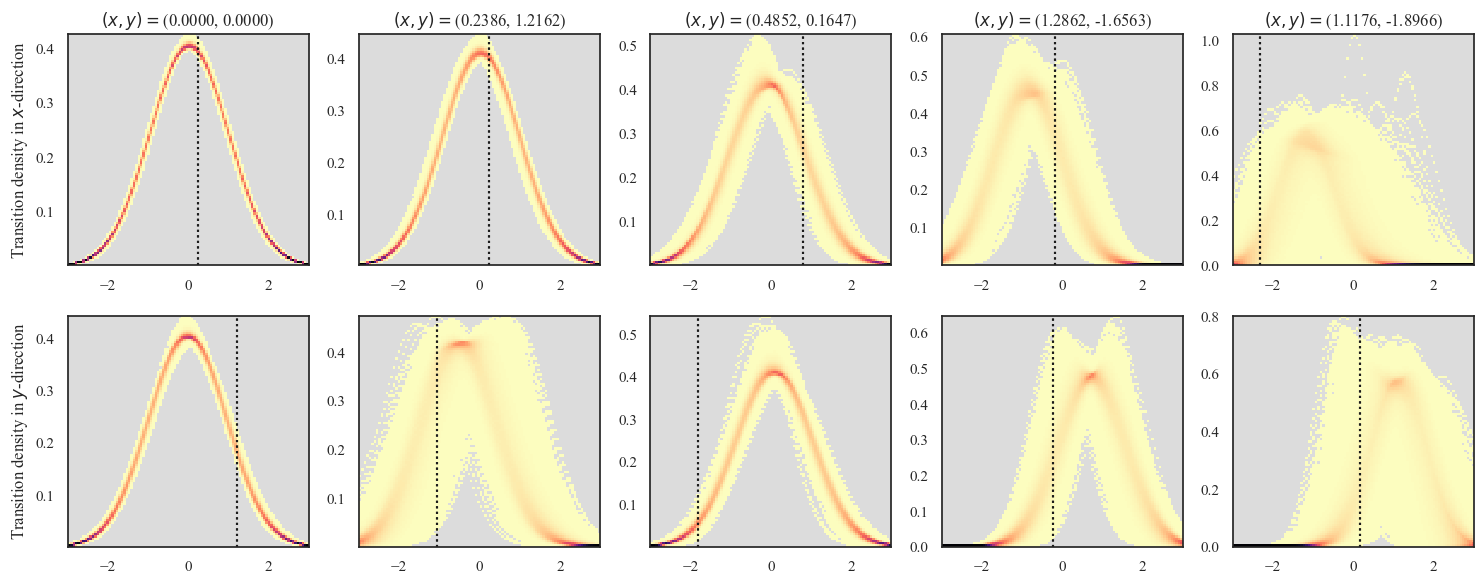

In [10]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(15,6)

all_supp_coords_x = []
all_dens_coords_x = []

all_supp_coords_y = []
all_dens_coords_y = []

for i in range(0,5):

    all_supp_coords_ix = []
    all_dens_coords_ix = []

    all_supp_coords_iy = []
    all_dens_coords_iy = []

    x_dist_mean = np.zeros(100)
    y_dist_mean = np.zeros(100)
    
    for n in range(0,N_samples):
        
        x_sup = np.linspace(-3, 3, 100)
        y_sup = np.linspace(-3, 3, 100)

        x_mean, x_logvar, y_mean, y_logvar = outputs[n,i,:]
        
        x_dist = norm(x_mean,np.sqrt(np.exp(x_logvar)))
        all_supp_coords_ix.extend(x_sup)
        all_dens_coords_ix.extend(x_dist.pdf(x_sup))

        point = trajectory[0, i, :]
        x, y, _ = point
        ax[0,i].set_title(r'$(x,y) = $' + f"({x:.4f}, {y:.4f})")
        next_point = trajectory[0, i+1, :]
        
        y_dist = norm(y_mean,np.sqrt(np.exp(y_logvar)))
        
        all_supp_coords_iy.extend(y_sup)
        all_dens_coords_iy.extend(y_dist.pdf(y_sup))
        
        point = trajectory[0, i, :]
        x, y, _ = point
        next_point = trajectory[0, i+1, :]
    
    all_supp_coords_x.append(all_supp_coords_ix)
    all_dens_coords_x.append(all_dens_coords_ix)
    all_supp_coords_y.append(all_supp_coords_iy)
    all_dens_coords_y.append(all_dens_coords_iy)
    
    
    ax[0,i].axvline(next_point[0]-x,linestyle = 'dotted',color = 'k')
    ax[1,i].axvline(next_point[1]-y,linestyle = 'dotted',color = 'k')

    h = ax[0,i].hist2d(
    all_supp_coords_x[i], 
    all_dens_coords_x[i], 
    bins=(100, 100), 
    cmap='magma_r',
    cmin=1)
    ax[0,i].set_facecolor('gainsboro')

    h = ax[1,i].hist2d(
    all_supp_coords_y[i], 
    all_dens_coords_y[i], 
    bins=(100, 100), 
    cmap='magma_r',
    cmin=1)
    ax[1,i].set_facecolor('gainsboro')

    point = trajectory[0, i, :]
    x, y, _ = point
    ax[0,i].set_title(r'$(x,y) = $' + f"({x:.4f}, {y:.4f})")
    next_point = trajectory[0, i+1, :]

    x, y, _ = point
    next_point = trajectory[0, i+1, :]
    
    ax[0,i].axvline(next_point[0]-x,linestyle = 'dotted',color = 'k')
    ax[1,i].axvline(next_point[1]-y,linestyle = 'dotted',color = 'k')


ax[0,0].set_ylabel(r'Transition density in $x$-direction')
ax[1,0].set_ylabel(r'Transition density in $y$-direction')

plt.tight_layout()
plt.show()

To more effectively compare these surrogate policies, we use a separate testing ensemble of empirical policies that were not used to fit the PCE.

In [11]:
import continuous_grid_helper as h

testing_forward_model_ensemble = []
mus = []
N = 250

for n in range(N):

    forward_model, backward_model, _, _ = h.setup_experiment()

    state_dict_for = torch.load('testing_ensemble/cont_for_gfn_quad_fixed' + str(n+1) + '.pth')
    forward_model.load_state_dict(state_dict_for)
    forward_model.eval()
    testing_forward_model_ensemble.append(forward_model)

test_policy_output = np.zeros((N,20))

for i in range(0,5):
    for j, forward_model in enumerate(testing_forward_model_ensemble):
        x_mean, x_var, y_mean, y_var = h.extract_dist_at_point(forward_model,trajectory[:,i,:])
        test_policy_output[j,(i*4):((i*4)+4)] = np.array([x_mean, np.log(x_var), y_mean, np.log(y_var)])

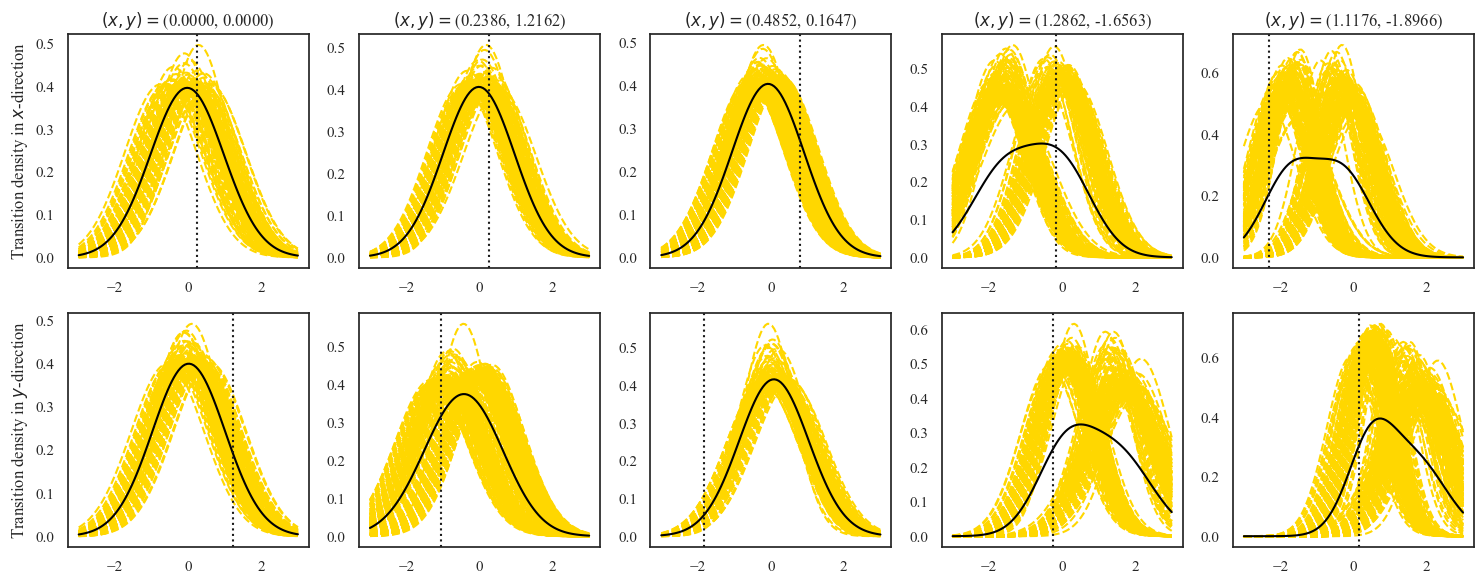

In [12]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(15,6)

for i in range(0,5):
    
    x_dist_mean = np.zeros(100)
    y_dist_mean = np.zeros(100)
    
    for j, forward_model in enumerate(testing_forward_model_ensemble):
        x_dist, y_dist = h.extract_flow_at_point(forward_model,trajectory[:,i,:])
        x_sup = np.linspace(-3, 3, 100)
        y_sup = np.linspace(-3, 3, 100)

        ax[0,i].plot(x_sup,x_dist.pdf(x_sup),color = 'gold',linestyle = 'dashed',label=r'$\mu = $' + f"{x_dist.mean():.2f}, " + r'$\sigma = $' + f"{x_dist.std():.2f}")
        x_dist_mean += x_dist.pdf(x_sup)/len(testing_forward_model_ensemble)
        point = trajectory[0, i, :]
        x, y, _ = point
        ax[0,i].set_title(r'$(x,y) = $' + f"({x:.4f}, {y:.4f})")
        next_point = trajectory[0, i+1, :]
        

        ax[1,i].plot(y_sup,y_dist.pdf(y_sup),color = 'gold',linestyle = 'dashed',label=r'$\mu = $' + f"{y_dist.mean():.2f}, " + r'$\sigma = $' + f"{y_dist.std():.2f}")
        y_dist_mean += y_dist.pdf(y_sup)/len(testing_forward_model_ensemble)
        point = trajectory[0, i, :]
        x, y, _ = point
        next_point = trajectory[0, i+1, :]
    
    ax[0,i].plot(x_sup,x_dist_mean,color = 'black')
    ax[1,i].plot(y_sup,y_dist_mean,color = 'black')
    
    ax[0,i].axvline(next_point[0]-x,linestyle = 'dotted',color = 'k')
    ax[1,i].axvline(next_point[1]-y,linestyle = 'dotted',color = 'k')


ax[0,0].set_ylabel(r'Transition density in $x$-direction')
ax[1,0].set_ylabel(r'Transition density in $y$-direction')
plt.tight_layout()
plt.show()

## Comparison to a multilayer perceptron

In [14]:
class MLPPolicy(nn.Module):
    def __init__(self, hidden_sizes=[64, 64], num_actions=20):
        super().__init__()
        layers = []
        input_dim = 4
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, num_actions))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.net(x)
        return logits

We train this MLP on the same input-output dataset as the PCE.

In [16]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(reward_input, dtype=torch.float32),
    torch.tensor(policy_output, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

model = MLPPolicy()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    for xb, yb in dataloader:
        pred = model(xb)
        loss = F.mse_loss(pred, yb)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch}, loss = {loss.item():.4f}")

mlp_outputs = model(torch.tensor(input_sample.T,dtype=torch.float32)).detach().numpy()
mlp_outputs = mlp_outputs.reshape(mlp_outputs.shape[0],5,4)

epoch 0, loss = 0.3527
epoch 1, loss = 0.2889
epoch 2, loss = 0.2469
epoch 3, loss = 0.2032
epoch 4, loss = 0.1534
epoch 5, loss = 0.1484
epoch 6, loss = 0.1224
epoch 7, loss = 0.1349
epoch 8, loss = 0.1457
epoch 9, loss = 0.1368
epoch 10, loss = 0.1284
epoch 11, loss = 0.1217
epoch 12, loss = 0.1160
epoch 13, loss = 0.1175
epoch 14, loss = 0.1267
epoch 15, loss = 0.1332
epoch 16, loss = 0.1299
epoch 17, loss = 0.1226
epoch 18, loss = 0.1183
epoch 19, loss = 0.1162
epoch 20, loss = 0.1121
epoch 21, loss = 0.1282
epoch 22, loss = 0.1082
epoch 23, loss = 0.1136
epoch 24, loss = 0.1054
epoch 25, loss = 0.1162
epoch 26, loss = 0.1336
epoch 27, loss = 0.1189
epoch 28, loss = 0.1155
epoch 29, loss = 0.1247
epoch 30, loss = 0.1290
epoch 31, loss = 0.1235
epoch 32, loss = 0.1297
epoch 33, loss = 0.0930
epoch 34, loss = 0.1283
epoch 35, loss = 0.1120
epoch 36, loss = 0.1009
epoch 37, loss = 0.1149
epoch 38, loss = 0.1134
epoch 39, loss = 0.1276
epoch 40, loss = 0.0985
epoch 41, loss = 0.1055
ep

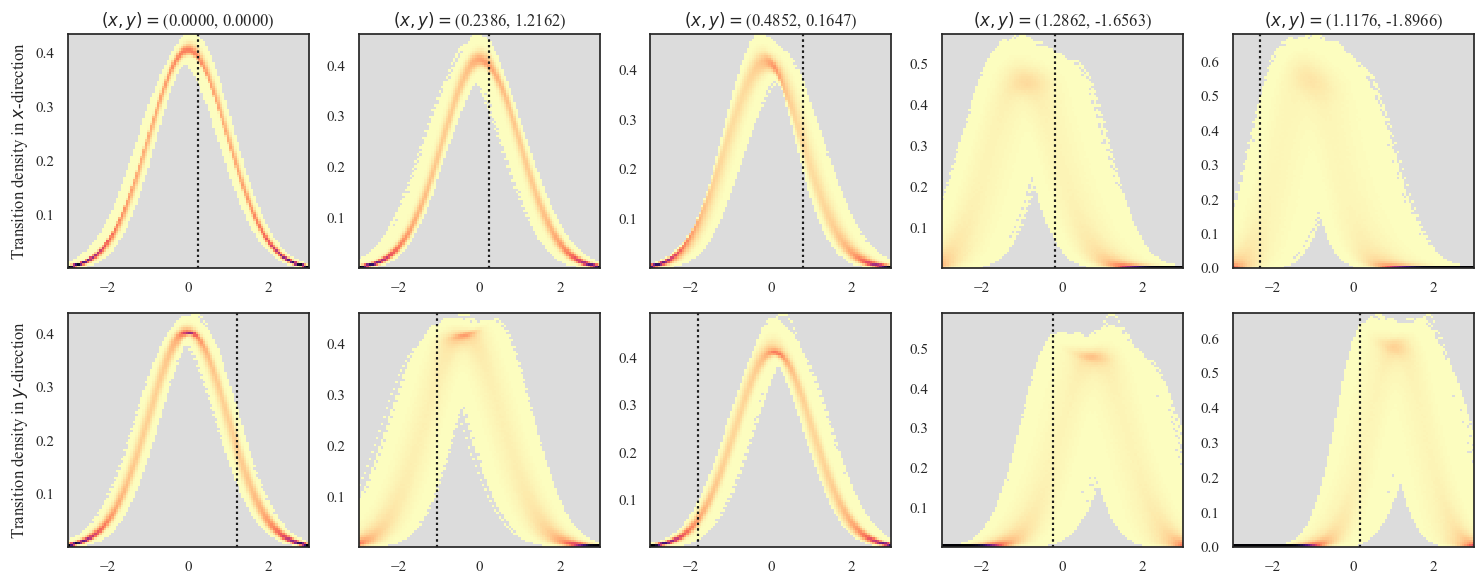

In [18]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(15,6)

all_supp_coords_x = []
all_dens_coords_x = []

all_supp_coords_y = []
all_dens_coords_y = []

for i in range(0,5):

    all_supp_coords_ix = []
    all_dens_coords_ix = []

    all_supp_coords_iy = []
    all_dens_coords_iy = []

    x_dist_mean = np.zeros(100)
    y_dist_mean = np.zeros(100)
    
    for n in range(0,N_samples):
        
        x_sup = np.linspace(-3, 3, 100)
        y_sup = np.linspace(-3, 3, 100)

        x_mean, x_logvar, y_mean, y_logvar = mlp_outputs[n,i,:]
        
        x_dist = norm(x_mean,np.sqrt(np.exp(x_logvar)))
        all_supp_coords_ix.extend(x_sup)
        all_dens_coords_ix.extend(x_dist.pdf(x_sup))

        point = trajectory[0, i, :]
        x, y, _ = point
        ax[0,i].set_title(r'$(x,y) = $' + f"({x:.4f}, {y:.4f})")
        next_point = trajectory[0, i+1, :]
        
        y_dist = norm(y_mean,np.sqrt(np.exp(y_logvar)))
        
        all_supp_coords_iy.extend(y_sup)
        all_dens_coords_iy.extend(y_dist.pdf(y_sup))
        
        point = trajectory[0, i, :]
        x, y, _ = point
        next_point = trajectory[0, i+1, :]
    
    all_supp_coords_x.append(all_supp_coords_ix)
    all_dens_coords_x.append(all_dens_coords_ix)
    all_supp_coords_y.append(all_supp_coords_iy)
    all_dens_coords_y.append(all_dens_coords_iy)
    
    
    ax[0,i].axvline(next_point[0]-x,linestyle = 'dotted',color = 'k')
    ax[1,i].axvline(next_point[1]-y,linestyle = 'dotted',color = 'k')

    h = ax[0,i].hist2d(
    all_supp_coords_x[i], 
    all_dens_coords_x[i], 
    bins=(100, 100), 
    cmap='magma_r',
    cmin=1)
    ax[0,i].set_facecolor('gainsboro')

    h = ax[1,i].hist2d(
    all_supp_coords_y[i], 
    all_dens_coords_y[i], 
    bins=(100, 100), 
    cmap='magma_r',
    cmin=1)
    ax[1,i].set_facecolor('gainsboro')

    point = trajectory[0, i, :]
    x, y, _ = point
    ax[0,i].set_title(r'$(x,y) = $' + f"({x:.4f}, {y:.4f})")
    next_point = trajectory[0, i+1, :]

    x, y, _ = point
    next_point = trajectory[0, i+1, :]
    
    ax[0,i].axvline(next_point[0]-x,linestyle = 'dotted',color = 'k')
    ax[1,i].axvline(next_point[1]-y,linestyle = 'dotted',color = 'k')


ax[0,0].set_ylabel(r'Transition density in $x$-direction')
ax[1,0].set_ylabel(r'Transition density in $y$-direction')

plt.tight_layout()
plt.show()